In [106]:
import requests
import pandas as pd
from geopy.geocoders import Nominatim
import pytz
from datetime import datetime
import numpy as np
from IPython.display import display, clear_output, Markdown
from tabulate import tabulate

devices_api = 'https://api.smartcitizen.me/v0/devices/'

## Workshops Settings

In [107]:
# When the workshops started
#date = datetime(2018, 11, 1, 0, 0, 0, tzinfo=pytz.utc)

# Workshops sites
#places = ['Bottrop, DE']
#places = [['Bottrop, DE'], ['Vantaa, FI'], 'Bologna, IT', 'Hasselt, BE', 'Surrey, UK']

places = [{
	'town': 'Bottrop, DE',
	'start_date': '2018-11-01T00:00:00Z',
	'blacklist': [5227]
},
{
	'town': 'Vantaa, FI',
	'start_date': '2018-11-01T00:00:00Z',
	'blacklist': [5075, 5072, 5073, 5071]
},
{
	'town': 'Bologna, IT',
	'start_date': '2018-11-01T00:00:00Z',
    'blacklist': [5033, 5036, 5040, 5034, 5035, 5042, 5037, 5043, 5039, 5038, 5045, 5044, 5041]
},
{
	'town': 'Hasselt, BE',
	'start_date': '2018-11-01T00:00:00Z'
},
{
	'town': 'Surrey, UK',
	'start_date': '2018-11-01T00:00:00Z'
}]

In [108]:
def devices(place):

    geolocator = Nominatim(user_agent="iSCAPE")

    location = geolocator.geocode(place['town'])

    location_str = str(location.latitude) + ',' + str(location.longitude)

    params = {'near': location_str, 'within': 1000, 'per_page': 100}

    req = requests.get(devices_api, params=params).json()
    
    date = pd.to_datetime(place['start_date'])
    
    # for item in req:
    #     print item
    devices = pd.DataFrame(req)
    devices['iscape_site'] = place['town']
    devices['added_at'] = pd.to_datetime(devices['added_at'])
    devices['last_reading_at'] = pd.to_datetime(devices['last_reading_at'])
    devices = devices[devices['last_reading_at'] > date]
    devices = devices[devices['added_at'] > date]

    devices.index = devices['id']

    # Probably this could be done via list comprehension but it's clearer this way
    # The problem comes with the dict within the pandas series, that it's not directly indexable from pandas (same sintax)
    list_kits = list()
    for item in devices.kit:
        if item['id'] == 20: list_kits = devices[devices.kit == item].index
    
    # Filter devices
    devices = devices.loc[list_kits]

    
    # Exclude some devices manually
    if 'blacklist' in place:
        devices = devices.loc[~devices['id'].isin(place['blacklist'])]
    
    devices['total_readings'] = devices.apply(lambda row: readings(row), axis=1)
    
    devices['total_readings_days'] = devices.apply(lambda row: row['total_readings'] / (60.0*24.0), axis = 1)
    devices['total_days_last_reading'] = devices.apply(lambda row: max(0, (row['last_reading_at'] - row['added_at']).days), axis=1)
    devices['total_days_since_registered'] = devices.apply(lambda row: (datetime.now() - row['added_at']).days, axis=1)

    devices['user_name'] = devices.apply(lambda row: row['owner']['username'], axis = 1)
    
    devices['ratio_readings_days'] = devices.apply(lambda row: ratio_days(row), axis = 1)

    devices['town'] = devices.apply(lambda row: row['data']['location']['city'], axis = 1)

    devices['id'] = devices['id'].astype(str)
    return devices

def ratio_days(row):
    return row['total_readings_days'] / row['total_days_since_registered'] if row['total_days_since_registered'] else np.nan

def readings(row):

    params = {'from': date.isoformat(), 'to': datetime.now().isoformat(), 'rollup': '60s', 'sensor_id': 10 }

    req = requests.get(devices_api + str(row['id']) + '/readings', params=params).json()

    readings = req['readings']

    total_readings = len(readings)

    return total_readings

In [109]:
sites = []
for place in places:
    
    sites.append(devices(place))
    
sites = pd.concat(sites)
display(sites)   

,added_at,data,description,id,kit,last_reading_at,mac_address,name,owner,state,...,user_tags,uuid,iscape_site,total_readings,total_readings_days,total_days_last_reading,total_days_since_registered,user_name,ratio_readings_days,town
id,,,,,,,,,,,,,,,,,,,,,
5127,2018-11-13 18:21:58,"{u'sensors': [{u'raw_value': 1623.83, u'uuid':...",iSCAPE Citizen Kit,5127,"{u'description': u'iSCAPE Citizen Kit ', u'upd...",2018-11-15 09:18:08,[FILTERED],Neighborly Crocodile Note,"{u'username': u'pascal.krueger', u'uuid': u'97...",has_published,...,"[iSCAPE, Inside]",23346401-ab70-4ed8-b820-2bf52f6dd53b,"Bottrop, DE",17,0.011806,1,8,pascal.krueger,0.001476,Bottrop
5126,2018-11-13 18:20:33,"{u'sensors': [{u'raw_value': 12.47, u'uuid': u...",iSCAPE Citizen Kit,5126,"{u'description': u'iSCAPE Citizen Kit ', u'upd...",2018-11-13 23:59:58,[FILTERED],Polaris,"{u'username': u'AlexChristian', u'uuid': u'd18...",has_published,...,"[iSCAPE, First Floor, Inside]",d44e84fa-1fcc-4d2e-970b-9335bc7c05a6,"Bottrop, DE",210,0.145833,0,8,AlexChristian,0.018229,Bottrop
5125,2018-11-13 18:19:44,"{u'sensors': [{u'raw_value': 119.44, u'uuid': ...",iSCAPE Citizen Kit,5125,"{u'description': u'iSCAPE Citizen Kit ', u'upd...",2018-11-13 18:28:04,[FILTERED],#Team Mia Carina,"{u'username': u'Carina Christian', u'uuid': u'...",has_published,...,"[iSCAPE, Inside, First Floor]",d1e4a5ef-a100-4f4c-b753-93ef0d0d9b9c,"Bottrop, DE",17,0.011806,0,8,Carina Christian,0.001476,Bottrop
5128,2018-11-13 18:29:41,"{u'sensors': [{u'raw_value': 107.21, u'uuid': ...",iSCAPE Citizen Kit,5128,"{u'description': u'iSCAPE Citizen Kit ', u'upd...",2018-11-13 17:31:51,[FILTERED],Bottrop Citizen Science - iSCAPE Team,"{u'username': u'iscape_TUDO_team', u'uuid': u'...",has_published,...,"[iSCAPE, Research, Window, First Floor]",1eb51ac3-34e3-4eea-a5f0-8adb7623b20f,"Bottrop, DE",63,0.043750,0,8,iscape_TUDO_team,0.005469,Bottrop
5138,2018-11-14 16:43:00,"{u'sensors': [{u'raw_value': 771.9, u'uuid': u...",iSCAPE Citizen Kit,5138,"{u'description': u'iSCAPE Citizen Kit ', u'upd...",2018-11-21 07:26:31,[FILTERED],Kit Cat,"{u'username': u'day1patch', u'uuid': u'5d719d7...",has_published,...,"[iSCAPE, Outside, Balcony]",071981f4-4503-4eb1-b75c-32a05bd4a5e5,"Bottrop, DE",5146,3.573611,6,8,day1patch,0.446701,Bottrop
5170,2018-11-16 06:33:45,"{u'sensors': [{u'raw_value': 3.6, u'uuid': u'a...",iSCAPE Citizen Kit,5170,"{u'description': u'iSCAPE Citizen Kit ', u'upd...",2018-11-16 15:07:51,[FILTERED],Yummy Anagram Anagram,"{u'username': u'OFI Gov', u'uuid': u'8bc3c336-...",has_published,...,"[iSCAPE, Second Floor, Experimental, Outside, ...",793c592a-b07d-4015-89df-3f71498980bb,"Bottrop, DE",512,0.355556,0,6,OFI Gov,0.059259,Bottrop
5148,2018-11-15 09:25:46,"{u'sensors': [{u'raw_value': 1.02, u'uuid': u'...",iSCAPE Citizen Kit,5148,"{u'description': u'iSCAPE Citizen Kit ', u'upd...",2018-11-22 17:03:45,[FILTERED],PAKR-KAFO,"{u'username': u'pascal.krueger', u'uuid': u'97...",has_published,...,"[iSCAPE, Inside, Outside, Window]",11b0e3b5-2b05-4264-a742-c060a8020972,"Bottrop, DE",5713,3.967361,7,7,pascal.krueger,0.566766,Bottrop
5221,2018-11-20 13:14:15,"{u'sensors': [{u'raw_value': 0.0, u'uuid': u'a...",iSCAPE Citizen Kit,5221,"{u'description': u'iSCAPE Citizen Kit ', u'upd...",2018-11-22 17:04:05,[FILTERED],LK-BOT,"{u'username': u'LorenzKerwer', u'uuid': u'c19b...",has_published,...,[iSCAPE],8a47b437-4325-4fb7-b1ca-d8c0d80f4c1d,"Bottrop, DE",3056,2.122222,2,2,LorenzKerwer,1.061111,Bottrop
5140,2018-11-14 19:27:30,"{u'sensors': [{u'raw_value': 112.02, u'uuid': ...",iSCAPE Citizen Kit,5140,"{u'description': u'iSCAPE Citizen Kit ', u'upd...",2018-11-14 22:47:46,[FILTERED],4635,"{u'username': u'Raphaela', u'uuid': u'60f42d94...",has_published,...,"[iSCAPE, Outside, First Floor, Balcony]",85fa5668-c9ec-4674-8074-5b9d42be26a0,"Bottrop, DE",386,0.268056,0,7,Raphaela,0.038294,Gladbeck


## Charts report for all sites

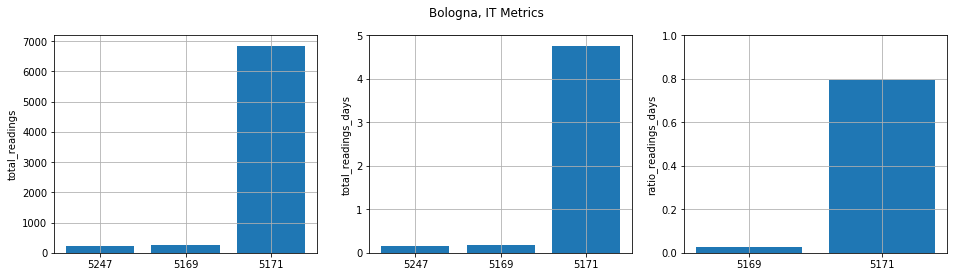

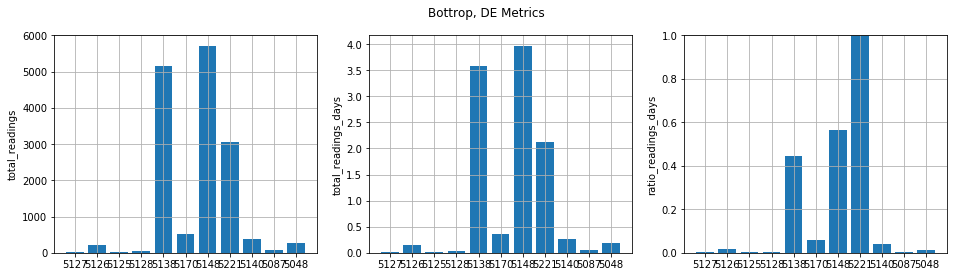

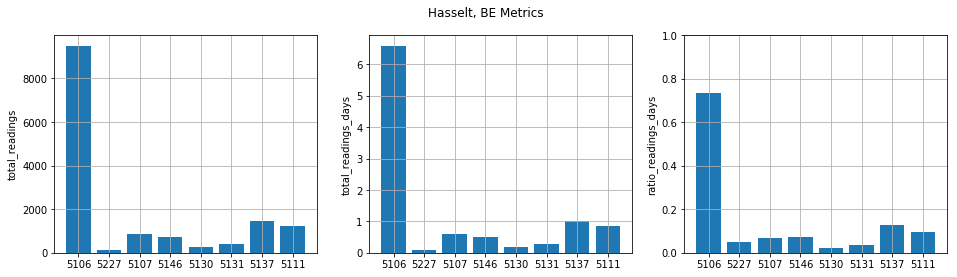

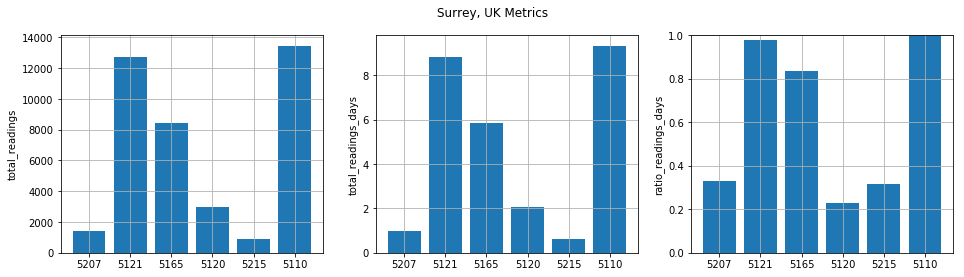

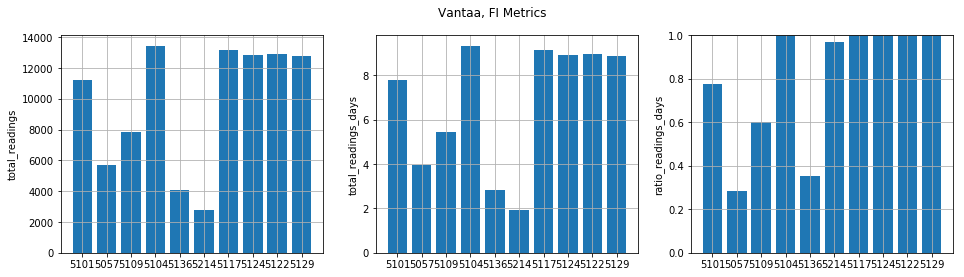

In [110]:
import matplotlib.pyplot as plot
% matplotlib inline

gg = [x for _, x in sites.groupby('iscape_site')]

for i in gg:
    i = i[['id', 'iscape_site', 'ratio_readings_days', 'total_readings', 'total_readings_days', 'total_days_last_reading', 'total_days_since_registered']]
    list_sites =  i['iscape_site'].values
    fig, axes = plot.subplots(1, 3, figsize = (16,4))
    axes[0].bar(i['id'], i ['total_readings'])
    axes[0].set_ylabel('total_readings')
    axes[0].grid(True)

    axes[1].bar(i['id'], i['total_readings_days'])
    axes[1].set_ylabel('total_readings_days')
    axes[1].grid(True)

    axes[2].bar(i['id'], i['ratio_readings_days'])
    axes[2].set_ylabel('ratio_readings_days')
    axes[2].set_ylim([0, 1])
    axes[2].grid(True)
    fig.suptitle(list_sites[0] + ' Metrics')
    

## Table report for all sites

In [111]:
clean_sites = sites.drop(['data', 'description','added_at','last_reading_at','kit', 'total_days_since_registered', 'total_days_last_reading','mac_address', 'owner', 'state', 'system_tags', 'user_tags', 'uuid', 'updated_at' ], axis=1)  
    
clean_sites = clean_sites.sort_values(['iscape_site', 'total_readings'], ascending=[True, False])

clean_sites.index = clean_sites['id']

clean_sites = clean_sites[['iscape_site', 'name', 'user_name', 'ratio_readings_days', 'total_readings', 'town']]

clean_sites_print = clean_sites.copy()

clean_sites_print['ratio_readings_days'] = pd.Series(["{0:.2f}%".format(val * 100) for val in clean_sites_print['ratio_readings_days']], index = clean_sites.index)    

display(clean_sites_print)   

,iscape_site,name,user_name,ratio_readings_days,total_readings,town
id,,,,,,
5171,"Bologna, IT",Bologna's countryside,outside,79.27%,6849,Lizzano in Belvedere
5169,"Bologna, IT",BC60,Lui,2.85%,246,Bologna
5247,"Bologna, IT",17B8,Uomosupernova,nan%,234,Bologna
5148,"Bottrop, DE",PAKR-KAFO,pascal.krueger,56.68%,5713,Bottrop
5138,"Bottrop, DE",Kit Cat,day1patch,44.67%,5146,Bottrop
5221,"Bottrop, DE",LK-BOT,LorenzKerwer,106.11%,3056,Bottrop
5170,"Bottrop, DE",Yummy Anagram Anagram,OFI Gov,5.93%,512,Bottrop
5140,"Bottrop, DE",4635,Raphaela,3.83%,386,Gladbeck
5048,"Bottrop, DE",Friendly Cow Cow,lis.faulenbach91_97,1.13%,260,Dortmund


## Table report per site 

In [112]:
gg = [x for _, x in sites.groupby('iscape_site')]

for i in gg:
    
    clean_sites = i.drop(['data', 'description','added_at','last_reading_at','kit', 'total_days_last_reading','mac_address', 'owner', 'state', 'system_tags', 'user_tags', 'uuid', 'updated_at' ], axis=1)  
    
    clean_sites = clean_sites.sort_values(['iscape_site', 'total_readings'], ascending=[True, False])

    clean_sites.index = clean_sites['id']

    clean_sites = clean_sites[['iscape_site', 'name', 'user_name', 'total_days_since_registered', 'total_readings', 'ratio_readings_days']]
    
    clean_sites['ratio_readings_days'] = clean_sites.apply(lambda row: row['ratio_readings_days'] if row['ratio_readings_days'] <= 1 else 1, axis=1)
    
    clean_sites_print = clean_sites.copy()
    
    clean_sites_print['ratio_readings_days'] = pd.Series(["{0:.2f}%".format(val * 100) for val in clean_sites_print['ratio_readings_days']], index = clean_sites.index)    

    ## This is temporary for Markdown output...
    
    print '## ' + clean_sites['iscape_site'][0] + ' [' + str(len(i.index)) + ']'
    print '\n'
    
    clean_sites_print = clean_sites_print.drop(['iscape_site'], axis=1)  
    
    print tabulate(clean_sites_print, headers="keys", tablefmt="html")
    
    print '\n'
    print '\n'

## Bologna, IT [3]


<table>
<thead>
<tr><th style="text-align: right;">  id</th><th>name                 </th><th>user_name    </th><th style="text-align: right;">  total_days_since_registered</th><th style="text-align: right;">  total_readings</th><th>ratio_readings_days  </th></tr>
</thead>
<tbody>
<tr><td style="text-align: right;">5171</td><td>Bologna's countryside</td><td>outside      </td><td style="text-align: right;">                            6</td><td style="text-align: right;">            6849</td><td>79.27%               </td></tr>
<tr><td style="text-align: right;">5169</td><td>BC60                 </td><td>Lui          </td><td style="text-align: right;">                            6</td><td style="text-align: right;">             246</td><td>2.85%                </td></tr>
<tr><td style="text-align: right;">5247</td><td>17B8                 </td><td>Uomosupernova</td><td style="text-align: right;">                            0</td><td style="text-align: right;">       

</table>






## Aggregated report for all sites

,id,total_days_since_registered,total_readings,ratio_readings_days
iscape_site,,,,
"Vantaa, FI",10,8,96742,80%
"Surrey, UK",6,6,39911,62%
"Bottrop, DE",11,8,15460,20%
"Hasselt, BE",8,7,14590,15%
"Bologna, IT",3,4,7329,61%


<table>
<thead>
<tr><th>Sites      </th><th style="text-align: right;">  Participants</th><th style="text-align: right;">  Average Days registered</th><th style="text-align: right;">  Total Sensor Readings</th><th>Performance Average  </th></tr>
</thead>
<tbody>
<tr><td>Vantaa, FI </td><td style="text-align: right;">            10</td><td style="text-align: right;">                        8</td><td style="text-align: right;">                  96742</td><td>80%                  </td></tr>
<tr><td>Surrey, UK </td><td style="text-align: right;">             6</td><td style="text-align: right;">                        6</td><td style="text-align: right;">                  39911</td><td>62%                  </td></tr>
<tr><td>Bottrop, DE</td><td style="text-align: right;">            11</td><td style="text-align: right;">                        8</td><td style="text-align: right;">                  15460</td><td>20%                  </td></tr>
<tr><td>Hasselt, BE</td><td style="text-align: 

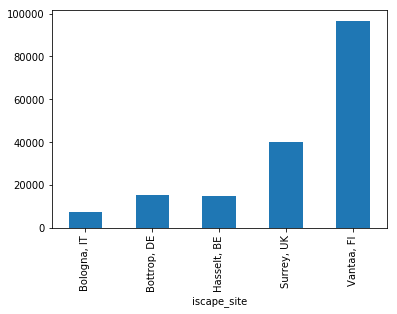

In [113]:
clean_sites = sites.drop(['data', 'description','added_at','last_reading_at','kit', 'total_days_last_reading','mac_address', 'owner', 'state', 'system_tags', 'user_tags', 'uuid', 'updated_at' ], axis=1)  
    
clean_sites = clean_sites.sort_values(['iscape_site', 'total_readings'], ascending=[True, False])

clean_sites.index = clean_sites['id']

clean_sites = clean_sites[['id', 'iscape_site', 'name', 'user_name', 'total_days_since_registered', 'total_readings', 'ratio_readings_days']]
    
clean_sites['ratio_readings_days'] = clean_sites.apply(lambda row: row['ratio_readings_days'] if row['ratio_readings_days'] <= 1 else 1, axis=1)
    
clean_sites_print = clean_sites.copy()
    
clean_sites_print['ratio_readings_days'] = pd.Series(["{0:.2f}%".format(val * 100) for val in clean_sites_print['ratio_readings_days']], index = clean_sites.index)    

sites_total_records2 = clean_sites.groupby(['iscape_site'])['total_readings'].sum()

sites_total_records3 = clean_sites.groupby(['iscape_site'])['ratio_readings_days'].mean()

sites_total_records4 = clean_sites.groupby(['iscape_site'])['total_days_since_registered'].mean()

sites_total_records6 = clean_sites.groupby(['iscape_site'])['id'].count()

sites_total_records2.plot.bar(x='Living Labs', y='Readings')

sites_total_records5 = pd.concat([sites_total_records6, sites_total_records4, sites_total_records2, sites_total_records3], axis=1)

sites_total_records5['total_days_since_registered'] = sites_total_records5['total_days_since_registered'].astype(int)

sites_total_records5['ratio_readings_days'] = pd.Series(["{0:.0f}%".format(val * 100) for val in sites_total_records5['ratio_readings_days']], index = sites_total_records5.index)    

sites_total_records5 = sites_total_records5.sort_values(['total_readings'], ascending=[False])

display(sites_total_records5)

print tabulate(sites_total_records5, ['Sites', 'Participants', 'Average Days registered', 'Total Sensor Readings', 'Performance Average'], tablefmt="html")

